## <span style="color: Navy"> Table des matières </span> 
##### 1.[Introduction](#.-Introduction)

##### 2.[Collecte des données](#.-Collecte_des_données)

##### 3.[Prétraitement](#.-Prétraitement)

##### 4.[Construction du modèle](#.-Construction_du_modèle)

##### 5.[Evaluation du modèle ](#.-Evaluation_du_modèle)



## <p style='text-align: center;'> Analyse des sentiments Tweets 😀 😢 </p> 

## <span style="color: Navy"> 1.Intorduction </span> 

<div style="text-align:center;">
<img src="images/Le flux de travail général de l'analyse des sentiments.png" alt="Analyse des sentiments: Processus" width="400" height="200">
</div>

***

Dans cette étude, notre objectif est de développer un modèle de NLP capable d'analyser les sentiments exprimés dans les tweets. nous utilisons un ensemble de données contenant des tweets pré-étiquetés avec leurs sentiments correspondants.


- L'ensemble de données comprend les colonnes suivantes:

<span Style="color:MediumBlue"> **Target:** </span>  : Cette colonne représente la polarité du sentiment exprimé dans le tweet, avec des valeurs de 0 pour les sentiments négatifs et 4 pour les sentiments positifs.

<span Style="color:MediumBlue"> **ids:** </span> : Chaque tweet est associé à un identifiant unique.

<span Style="color:MediumBlue"> **Date:** </span>  La date et l'heure de publication du tweet.

<span Style="color:MediumBlue"> **Flag** </span>  Un marqueur spécifiant l'origine des données, indiquant si les données proviennent d'une requête spécifique ou non.

<span Style="color:MediumBlue"> **user** </span>  Le nom d'utilisateur de l'auteur du tweet.

<span Style="color:MediumBlue"> **Text** </span>  Le contenu textuel du tweet exprimant le sentiment.

 ## <span style="color:Navy"> 2. Collecte des données </span>

****

<span style="color: DimGray"> **1.1 Importation des bibliothèques**  </span>

In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score,recall_score,f1_score
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import AdaBoostClassifier


<span Style="color: DimGray"> **1.2 Importation des données**</span> 

In [2]:
colonnes= ['ids', 'Target', 'text']
df1 = pd.read_csv('datasets\Sentiment140-MV-Train.csv',names=colonnes)
df2=pd.read_csv('datasets\Sentiment140-MV-Test.csv',names=colonnes)
df = pd.concat([df1, df2], ignore_index=True)

In [3]:
df.head()

,ids,Target,text
0,1834873030,1,USER_MENTION oh that sounds yummy we dont have...
1,2062647136,0,USER_MENTION theres so many fakes of you
2,2013029024,1,USER_MENTION um nothing new apart from street ...
3,2184368404,1,USER_MENTION USER_MENTION the day cnn started ...
4,2214865531,0,missing my dad my brother today


<span style="color:DimGray"> **1.3 exploration des données**</span>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19995 entries, 0 to 19994
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ids     19995 non-null  int64 
 1   Target  19995 non-null  int64 
 2   text    19995 non-null  object
dtypes: int64(2), object(1)
memory usage: 468.8+ KB


In [5]:
df.isnull().sum()

ids       0
Target    0
text      0
dtype: int64

In [6]:
df.duplicated().sum()

1782

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df['Target'].value_counts()

Target
1    11628
0     6585
Name: count, dtype: int64

## <span style="color:Navy"> 3. Prétraitement</span>

***

<span style="color:DimGray"> **3.1 Suppression des colonnes non-utiles** </span>

 <span style="color: DimGray"> **3.2 Covertion de Target 4 à 1**  </span> 

<span style="color: DimGray"> **3.3 Visualisation des données ( La distribution des classes)** </span> 

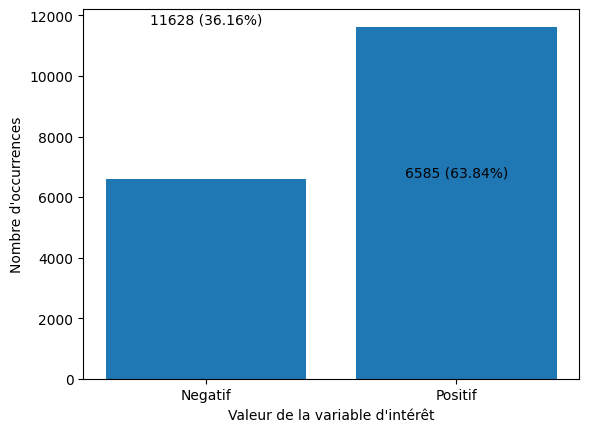

In [9]:
target_counts = df['Target'].value_counts()

# Calcul du proportion pour chaque valeur de la variable d'intérêt (Target)
target_proportions = df['Target'].value_counts(normalize=True)

# Création d'un graphique à barres pour visualiser la distribution
plt.bar(target_counts.index, target_counts.values)

# Ajoute des étiquettes des barres (nombre d'occurrences et proportion)
for i, count in enumerate(target_counts):
    proportion = target_proportions[i]
    plt.text(i, count, f"{count} ({proportion:.2%})", ha='center', va='bottom')

# Étiquetage de l'axe des x et y
plt.xlabel('Valeur de la variable d\'intérêt')
plt.ylabel('Nombre d\'occurrences')

# Ajoute d'une légende aux barres
plt.xticks(target_counts.index, ['Positif', 'Negatif'])

# Affichage du graphique
plt.show()

<span style="color:DimGray"> **3.4 Racinisation** </span> 

In [10]:
import re 
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [11]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [13]:
def lemmitizer(content):
    # Suppression des caractères non alphabétiques
    texte_nettoye = re.sub('[^a-zA-Z]', ' ', content)
    # Suppression des adresses URL
    content = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))', ' ', content)
    content = content.lower()
    # Tokenization
    tokens = content.split()
    # Lemmatisation et suppression des mots vides
    lemmitized_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    # Reconstruction du texte
    lemmitized_text = ' '.join(lemmitized_tokens)
    return lemmitized_text


# On applique le nettoyage du texte sur la colonne 'texte'
df['texte_nettoye'] = df['text'].apply(lemmitizer)

In [14]:
df.head()

,ids,Target,text,texte_nettoye
0,1834873030,1,USER_MENTION oh that sounds yummy we dont have...,user_mention sound yummy dont bloomingdales th...
1,2062647136,0,USER_MENTION theres so many fakes of you,user_mention there many fake
2,2013029024,1,USER_MENTION um nothing new apart from street ...,user_mention nothing new apart street fighter
3,2184368404,1,USER_MENTION USER_MENTION the day cnn started ...,user_mention user_mention day cnn started sour...
4,2214865531,0,missing my dad my brother today,missing dad brother today


<span style='color:DimGray'> **3.5 Visualisation** </spand>

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 

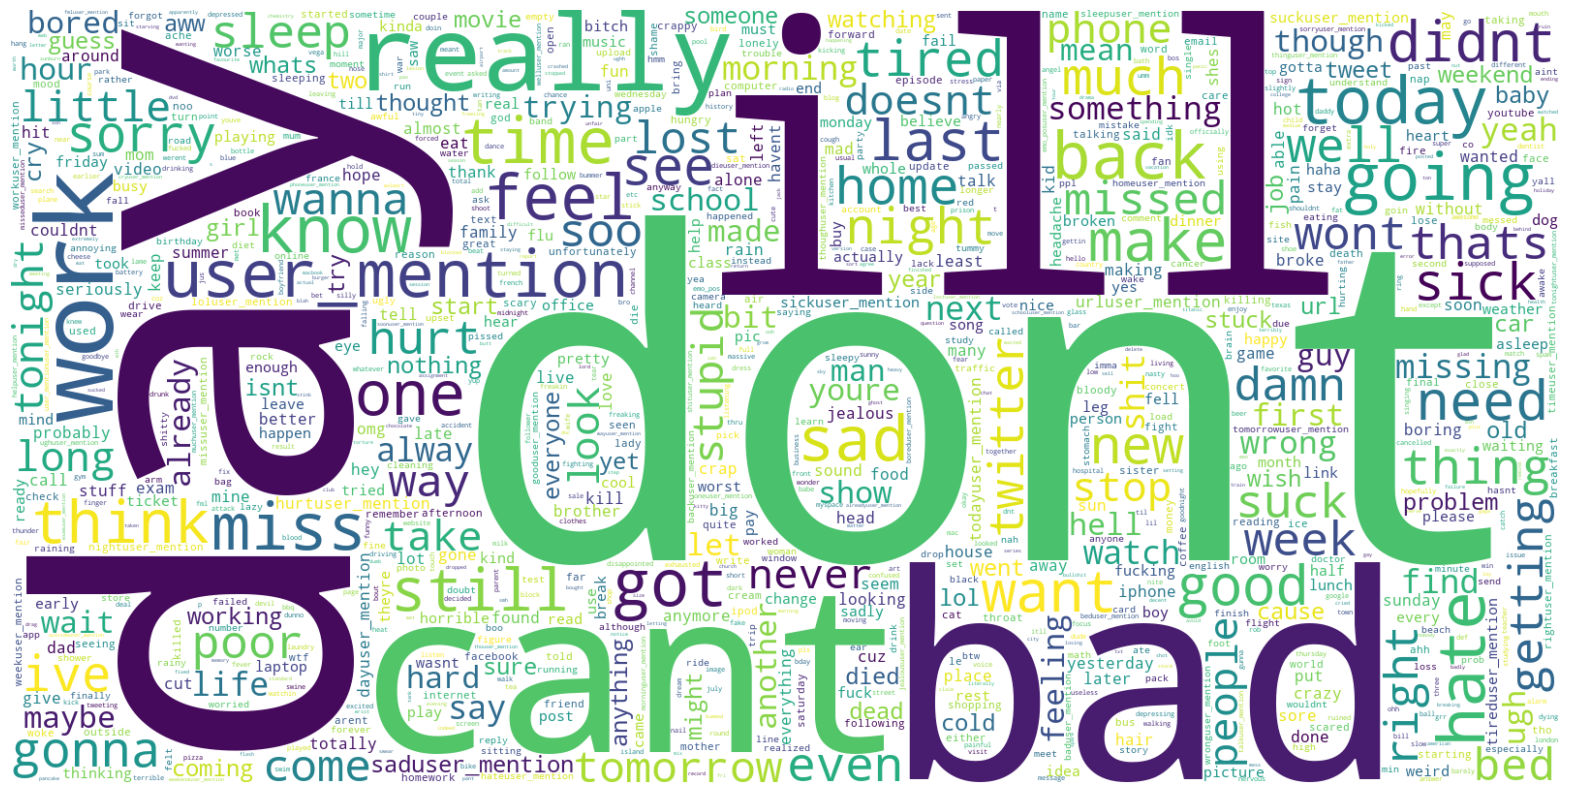

In [16]:
#filtrage des tweets Negatif 
data_neg= df[df['Target'] == 0]['texte_nettoye']

#Création d'un nuage de mots  
wc = WordCloud(max_words = 1000, width=1600, height = 800, collocations= False, background_color='white').generate("".join(data_neg))

#affichage 
plt.figure(figsize=(20, 20))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

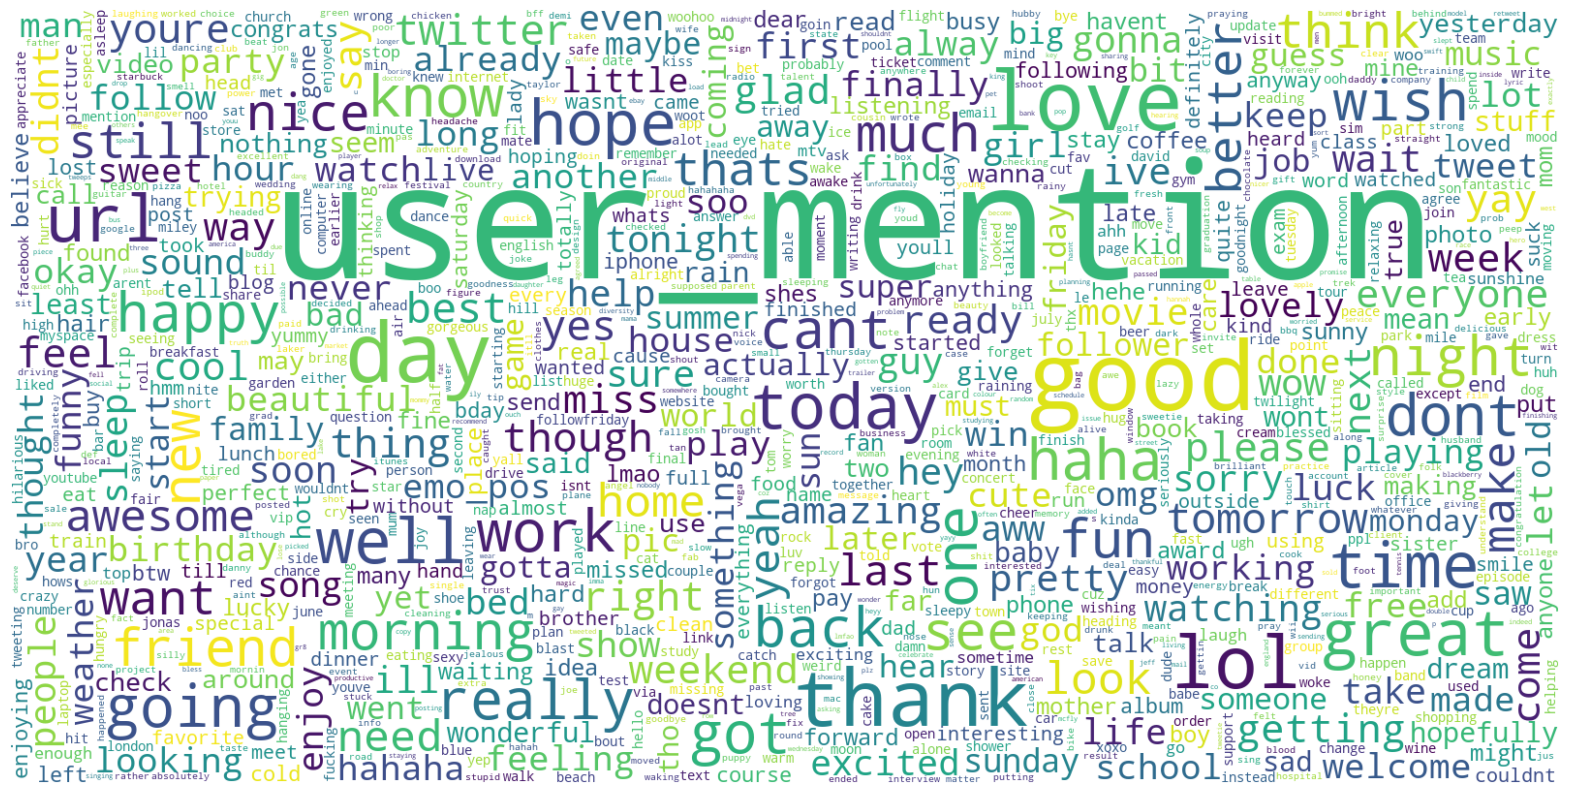

In [17]:
#filtrage des tweets posifit
data_neg = df[df['Target'] == 1]['texte_nettoye']

# Créer un nuage de mots à partir des données négatives
wc = WordCloud(max_words=1000, width=1600, height=800, collocations=False, background_color='white').generate(" ".join(data_neg))

# Afficher le nuage de mots
plt.figure(figsize=(20, 20))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

<span style='color:DimGray'> **3.6 Modélisation** </spand>

* Séparation des données

In [18]:
X=df['texte_nettoye'].values
Y=df['Target'].values

In [19]:
# Extraction des caractéristiques
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)

**X:** Représente la variable indépendante

**Y:** Représente la variable dépendante

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

<span style='color:DimGray'> **3.7 Convertion du texte en numérique** </spand>

 ## <span style='color:Navy'> 4.Construction du modèle </span>

****

<span style='color:DimGray'>  **Construction du modèle** </span> 

In [21]:
# Entraînement du modèle AdaBoost
model = AdaBoostClassifier(n_estimators=60, random_state=42,learning_rate=1)


In [22]:
model.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=1, n_estimators=60, random_state=42)

## <span style='color:Navy'> 5.Evaluation du modèle </span>

****

<span style='color:DimGray'> **5.1 Accuracy et précision** </span>

* Accuracy

In [23]:
Y_predict=model.predict(X_test)
accuracy=accuracy_score(y_test,Y_predict)
print('Accuracy:', accuracy)

Accuracy: 0.8111446609936865


* Précision

In [24]:
precision=precision_score(y_test,Y_predict)
precision

0.8579545454545454

In [25]:

f1 = f1_score(y_test, Y_predict)
print("F1 Score:", f1)

F1 Score: 0.8508885999133075


In [26]:

recall = recall_score(y_test, Y_predict)

print("Recall:", recall)


Recall: 0.8439380911435942


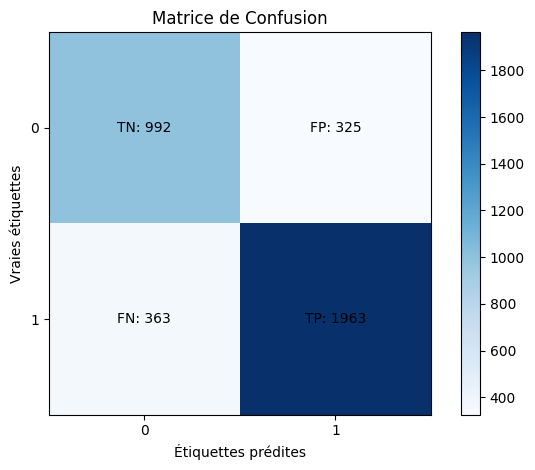

In [27]:
import itertools
import matplotlib.pyplot as plt
import numpy as np

# Créer la matrice de confusion
cm = confusion_matrix(y_test, Y_predict)

# Calculer les indicateurs de performance
tn, fp, fn, tp = cm.ravel()

# Afficher la matrice de confusion avec les indicateurs de performance
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)  # Utiliser le colormap Blues pour différentes nuances de bleu
plt.title('Matrice de Confusion')
plt.colorbar()
tick_marks = np.arange(len(model.classes_))
plt.xticks(tick_marks, model.classes_)
plt.yticks(tick_marks, model.classes_)



# Ajouter les indicateurs de performance
plt.text(0, 0, f'TN: {tn}', ha='center', va='center', color='black')
plt.text(1, 0, f'FP: {fp}', ha='center', va='center', color='black')
plt.text(0, 1, f'FN: {fn}', ha='center', va='center', color='black')
plt.text(1, 1, f'TP: {tp}', ha='center', va='center', color='black')

plt.ylabel('Vraies étiquettes')
plt.xlabel('Étiquettes prédites')
plt.tight_layout()
plt.show()

## <span style='color:Navy'> Prédiction  </span>

****

* Positif

In [28]:
# Text
text = "I'm happy!"

# Appliquer la fonction de racinisation à la nouvelle observation
lemmatized_new_text = lemmitizer(text)

#Conversion du text
vectorized_new_text = vectorizer.transform([lemmatized_new_text])

# Prédiction
prediction = model.predict(vectorized_new_text)

# Affichage des résultats
if prediction == 0:
    print("Sentiment est: négatif 😢.")
else:
    print("Sentiment est:  positif 😀.")

Sentiment est:  positif 😀.


* Négatif

In [29]:
# Text
text = "It's a sad day!"

# On applique la fonction de racinisation à la nouvelle observation
lemmatized_new_text = lemmitizer(text)

#Conversion du text
vectorized_new_text = vectorizer.transform([lemmatized_new_text])

# Prédiction
prediction = model.predict(vectorized_new_text)

# Affichage des résultats
if prediction == 0:
    print("Sentiment est: négatif 😢.")
else:
    print("Sentiment est:  positif 😀 .")

Sentiment est: négatif 😢.


* sauvgarder le modèle 

In [30]:
import pickle

In [31]:
filename = 'trained_model_RL.sav'
with open(filename, 'wb') as file:
    pickle.dump(model, file)


In [32]:
filename = 'vectorizer_RL.sav'
with open(filename, 'wb') as file:
    pickle.dump(vectorizer, file)
